<a href="https://colab.research.google.com/github/MS-H2020/Open/blob/main/Test8_efficient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp "/content/drive/MyDrive/Colab Notebooks/data.zip" .
!unzip data.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/train/1/n_05256.jpg  
  inflating: __MACOSX/data/train/1/._n_05256.jpg  
  inflating: data/train/1/n_01024.jpg  
  inflating: __MACOSX/data/train/1/._n_01024.jpg  
  inflating: data/train/1/n_03155.jpg  
  inflating: __MACOSX/data/train/1/._n_03155.jpg  
  inflating: data/train/1/n_04389.jpg  
  inflating: __MACOSX/data/train/1/._n_04389.jpg  
  inflating: data/train/1/n_03380.jpg  
  inflating: __MACOSX/data/train/1/._n_03380.jpg  
  inflating: data/train/1/n_00845.jpg  
  inflating: __MACOSX/data/train/1/._n_00845.jpg  
  inflating: data/train/1/n_04410.jpg  
  inflating: __MACOSX/data/train/1/._n_04410.jpg  
  inflating: data/train/1/n_02075.jpg  
  inflating: __MACOSX/data/train/1/._n_02075.jpg  
  inflating: data/train/1/n_04362.jpg  
  inflating: __MACOSX/data/train/1/._n_04362.jpg  
  inflating: data/train/1/n_01232.jpg  
  inflating: __MACOSX/data/train/1/._n_01232.jpg  
  inflating: data/train/1/n_00892.jpg  

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator( rescale=1./255, # 255で割ることで正規化
                              featurewise_center = False,
                              samplewise_center = False,
                              featurewise_std_normalization = False,
                              samplewise_std_normalization = False,
                              zca_whitening = False,
                              rotation_range = 10,
                              #width_shift_range = 0.3,
                              #height_shift_range = 0.3,
                              horizontal_flip = True,
                              vertical_flip = False,
                              validation_split = 0.2
                            )

In [ ]:
train_dir = './data/train'
BATCH_SIZE = 32

train_generator = datagen.flow_from_directory(
            train_dir,
            target_size=(256,256),
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            shuffle=True,
            subset = "training"
  )

val_generator = datagen.flow_from_directory(
            train_dir,
            target_size=(256,256),
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            shuffle=True,
            subset = "validation"
)

Found 3393 images belonging to 8 classes.
Found 845 images belonging to 8 classes.


In [ ]:
from tensorflow.keras.applications import efficientnet
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_DEPTH = 3

base_model = efficientnet.EfficientNetB7(
                  weights='imagenet',
                  include_top=False,
                  input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH)
                 )

base_model.trainable = False
"""
for layer in base_model.layers[-60:]:
    layer.trainable = True
"""

29084464/29084464 [==============================] - 1s 0us/step


'\nfor layer in base_model.layers[-60:]:\n    layer.trainable = True\n'

In [ ]:
from tensorflow.keras import datasets, layers, models, applications, optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten

CATEGORY_NUM = 8

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(512, activation='relu'),
    layers.Dense(CATEGORY_NUM, activation='softmax')
])

adam_low_rate = optimizers.Adam(learning_rate=0.001)

In [ ]:
# モデルの概要
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 8, 8, 1024)        7037504   
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 1024)              67109888  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               2

In [ ]:
# モデルを構築
model.compile(optimizer=adam_low_rate,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
from tensorflow import keras

# Early stoppingを適用してフィッティング
log = model.fit(
                  train_generator,
                  validation_data = val_generator,
                  steps_per_epoch = train_generator.samples // BATCH_SIZE,
                  validation_steps = val_generator.samples // BATCH_SIZE,
                  verbose=True,
                  callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)],
                  epochs = 200,
                  workers = 1
)

Epoch 1/200
106/106 [==============================] - 98s 775ms/step - loss: 4.0858 - accuracy: 0.4844 - val_loss: 0.8630 - val_accuracy: 0.6887
Epoch 2/200
106/106 [==============================] - 77s 726ms/step - loss: 0.9840 - accuracy: 0.6715 - val_loss: 0.8159 - val_accuracy: 0.6995
Epoch 3/200
106/106 [==============================] - 77s 727ms/step - loss: 0.8316 - accuracy: 0.7147 - val_loss: 0.8081 - val_accuracy: 0.7103
Epoch 4/200
106/106 [==============================] - 70s 665ms/step - loss: 0.7208 - accuracy: 0.7480 - val_loss: 0.8058 - val_accuracy: 0.7200
Epoch 5/200
106/106 [==============================] - 77s 731ms/step - loss: 0.6696 - accuracy: 0.7703 - val_loss: 0.7825 - val_accuracy: 0.7212
Epoch 6/200
106/106 [==============================] - 78s 738ms/step - loss: 0.5593 - accuracy: 0.7953 - val_loss: 0.7427 - val_accuracy: 0.7608
Epoch 7/200
106/106 [==============================] - 77s 726ms/step - loss: 0.5226 - accuracy: 0.8209 - val_loss: 0.8941 -

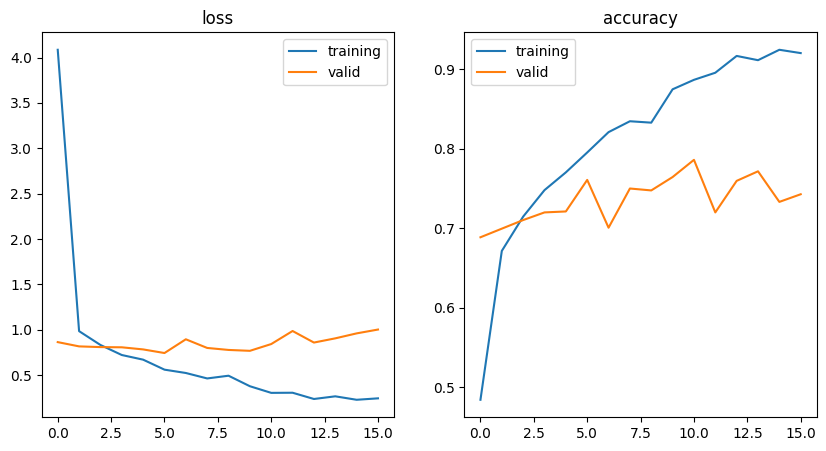

In [ ]:
import matplotlib.pyplot as plt
metrics = ['loss', 'accuracy']  # 使用する評価関数を指定
plt.figure(figsize=(10, 5))  # グラフを表示するスペースを用意

for i in range(len(metrics)):

    metric = metrics[i]

    plt.subplot(1, 2, i+1)  # figureを1×2のスペースに分ける
    plt.title(metric)

    plt_train = log.history[metric]
    plt_valid  = log.history['val_' + metric]

    plt.plot(plt_train, label='training')
    plt.plot(plt_valid, label='valid')
    plt.legend()

plt.savefig("metrics_eff.jpg")

In [ ]:
#Confution Matrix and Classification Report
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

Y_pred = model.predict(val_generator, val_generator.samples // BATCH_SIZE)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(val_generator.classes, y_pred))
print('Classification Report')
print(classification_report(val_generator.classes, y_pred, target_names=None))

27/27 [==============================] - 20s 654ms/step
Confusion Matrix
[[81 79  7 18 49  4  4]
 [84 84 12 23 50  3  2]
 [24 27  5  3 14  2  0]
 [26 27  3  5 12  0  1]
 [49 61  7 16 29  2  2]
 [ 3  4  0  1  2  0  0]
 [10  5  0  1  4  0  0]]
Classification Report
              precision    recall  f1-score   support

           0       0.29      0.33      0.31       242
           1       0.29      0.33      0.31       258
           2       0.15      0.07      0.09        75
           3       0.07      0.07      0.07        74
           4       0.18      0.17      0.18       166
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        20

    accuracy                           0.24       845
   macro avg       0.14      0.14      0.14       845
weighted avg       0.23      0.24      0.23       845



Text(50.722222222222214, 0.5, 'true')

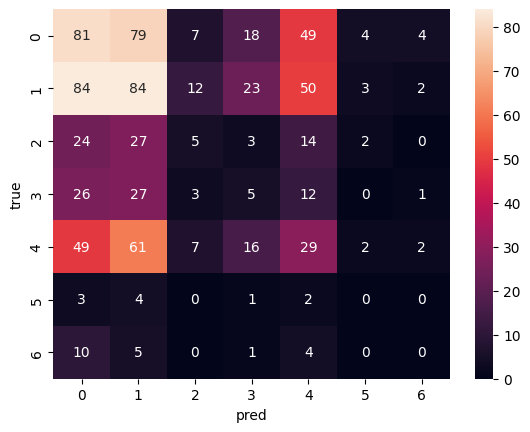

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.heatmap(confusion_matrix(val_generator.classes, y_pred), annot=True)
plt.xlabel("pred")
plt.ylabel('true')

In [ ]:
# 評価する。
test_loss, test_acc = model.evaluate(val_generator)

print(f"test loss: {test_loss:.2f}, test accuracy: {test_acc:.2%}")
model.save('/content/drive/MyDrive/Colab Notebooks/cnn_eff08.h5')

27/27 [==============================] - 14s 515ms/step - loss: 0.9504 - accuracy: 0.7550
test loss: 0.95, test accuracy: 75.50%


In [ ]:
#from tensorflow.keras.models import Model, load_model
#model = load_model('/content/drive/MyDrive/Colab Notebooks/cnn_dense121.h5')

In [ ]:
test_dir = './data/test'

import os
import shutil
import glob

os.makedirs('./data/test/dummy', exist_ok=True)
for image_path in glob.glob(test_dir + '/*'):
    shutil.move(image_path, test_dir + '/dummy')

In [ ]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(256,256), batch_size=64, class_mode=None, shuffle=False)

Found 1060 images belonging to 1 classes.


In [ ]:
import numpy as np
prediction = model.predict(test_generator)
results = np.argmax(prediction,axis=1)
print(results)
np.savetxt('/content/drive/MyDrive/Colab Notebooks/save_ored.csv', results, delimiter=',')

17/17 [==============================] - 17s 512ms/step
[1 3 4 ... 4 0 1]
